In [1]:
# CELL 1: Imports
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch
import torch.nn as nn
import timm
import torch.optim as optim
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report # Added for F1 score
from torch.optim.lr_scheduler import ReduceLROnPlateau # Added for LR scheduling

In [2]:
# CELL 2: Mount to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# CELL 3: Load and Augment the Dataset
seed = 30
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

# Dataset path and batch size
dataset_path = '/content/drive/MyDrive/corn_train/train' # Ensure this path is correct for your environment
batch_size = 8

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load entire dataset without transforms first
base_dataset = datasets.ImageFolder(root=dataset_path)

# Split dataset
dataset_size = len(base_dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.3 * dataset_size)) # 70/30 split
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Create subsets
train_dataset_subset = Subset(base_dataset, train_indices)
val_dataset_subset = Subset(base_dataset, val_indices)

# Apply transforms manually using a wrapper.
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: # Apply transform if provided
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformSubset(train_dataset_subset, train_transform)
val_dataset = TransformSubset(val_dataset_subset, val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
# CELL 4: Load the Model
# Determine the number of classes
num_classes = len(base_dataset.classes)
class_names_from_dataset = base_dataset.classes # Store class names for reporting
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names_from_dataset}")


# Load pre-trained DeiT model
model = timm.create_model('deit_tiny_patch16_224', pretrained=True)

# Modify the classification head
model.head = nn.Linear(model.head.in_features, num_classes)

# Define loss function and optimizer (Optimizer will be defined after class weights)
# Criterion will be defined in Cell 6 after calculating weights

Number of classes: 4
Class names: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [5]:
# CELL 5: GPU (Optional)
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

Using device: cuda


In [7]:
# CELL 6: Address Imbalance
from torch.nn import CrossEntropyLoss

# Manually defined class counts (ensure this order matches base_dataset.classes)
counts = {
    'Blight': 917,
    'Common_Rust': 1045,
    'Gray_Leaf_Spot': 459,
    'Healthy': 929
}

# Ensure class_names_from_dataset (from ImageFolder) are used to order counts correctly
if not all(name in counts for name in class_names_from_dataset):
    raise ValueError("Class names from dataset do not match keys in provided counts dictionary.")

ordered_counts = np.array([counts[name] for name in class_names_from_dataset])
total_samples = np.sum(ordered_counts)

# Calculate class weights: inverse frequency
weights_values = total_samples / (num_classes * ordered_counts)
weights = torch.tensor(weights_values, dtype=torch.float).to(device)

# Use weighted loss
criterion = CrossEntropyLoss(weight=weights)
print("Class weights loaded into CrossEntropyLoss:", weights.tolist())

# Define optimizer and LR scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5) # Monitor val_f1_macro

Class weights loaded into CrossEntropyLoss: [0.9133042693138123, 0.8014354109764099, 1.8246186971664429, 0.9015070199966431]


In [8]:
# CELL 7: Train the Model (with F1, Early Stopping, and LR Scheduler)

# Lists to save training metrics
train_losses = []
train_accuracies = []
train_f1_macros = [] # New
train_f1_weighteds = [] # New

val_losses = []
val_accuracies = []
val_f1_macros = [] # New
val_f1_weighteds = [] # New


# Early Stopping parameters
best_val_f1_macro = 0.0
patience_counter = 0
max_patience = 10 # Stop after 10 epochs of no improvement in val_f1_macro
best_model_path = '/content/drive/MyDrive/CornLeaf_DeiT.pth' # Path to save the best model

# Training loop
num_epochs = 25 # Original number of epochs, might be stopped early
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_train_labels = []
    all_train_preds = []

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    progress_bar_train = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in progress_bar_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())
        progress_bar_train.set_postfix({'loss': loss.item(), 'acc': correct/total if total > 0 else 0})


    train_loss = running_loss / total
    train_acc = correct / total
    train_f1_macro_epoch = f1_score(all_train_labels, all_train_preds, average='macro', zero_division=0)
    train_f1_weighted_epoch = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1 Macro: {train_f1_macro_epoch:.4f}, F1 Weighted: {train_f1_weighted_epoch:.4f}")
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_f1_macros.append(train_f1_macro_epoch)
    train_f1_weighteds.append(train_f1_weighted_epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    all_val_labels = []
    all_val_preds = []

    progress_bar_val = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in progress_bar_val:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())
            progress_bar_val.set_postfix({'loss': loss.item(), 'acc': val_correct/val_total if val_total > 0 else 0})


    val_loss /= val_total
    val_acc = val_correct / val_total
    val_f1_macro_epoch = f1_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
    val_f1_weighted_epoch = f1_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)

    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Macro: {val_f1_macro_epoch:.4f}, F1 Weighted: {val_f1_weighted_epoch:.4f}")
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_macros.append(val_f1_macro_epoch)
    val_f1_weighteds.append(val_f1_weighted_epoch)

    # Classification report for validation
    print("\nValidation Classification Report:")
    print(classification_report(all_val_labels, all_val_preds, target_names=class_names_from_dataset, zero_division=0))

    # LR Scheduler step
    scheduler.step(val_f1_macro_epoch) # Step with validation F1 macro

    # Early Stopping Check
    if val_f1_macro_epoch > best_val_f1_macro:
        best_val_f1_macro = val_f1_macro_epoch
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path) # Save only the state_dict
        print(f"Validation F1 Macro improved to {best_val_f1_macro:.4f}. Saving model to {best_model_path}")
    else:
        patience_counter += 1
        print(f"Validation F1 Macro did not improve. Patience: {patience_counter}/{max_patience}")

    if patience_counter >= max_patience:
        print(f"Early stopping at epoch {epoch+1} as validation F1 Macro did not improve for {max_patience} epochs.")
        break

# Load the best model weights after training is complete (or early stopped)
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model weights from {best_model_path}")


Epoch [1/25]


Train Loss: 0.4261, Accuracy: 0.8401, F1 Macro: 0.8110, F1 Weighted: 0.8439


Val Loss: 0.2742, Accuracy: 0.9087, F1 Macro: 0.8927, F1 Weighted: 0.9126

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.91      0.80      0.86       254
   Common_Rust       0.99      0.91      0.95       317
Gray_Leaf_Spot       0.66      0.91      0.77       151
       Healthy       1.00      1.00      1.00       286

      accuracy                           0.91      1008
     macro avg       0.89      0.91      0.89      1008
  weighted avg       0.93      0.91      0.91      1008

Validation F1 Macro improved to 0.8927. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth

Epoch [2/25]


Train Loss: 0.2771, Accuracy: 0.9060, F1 Macro: 0.8854, F1 Weighted: 0.9075


Val Loss: 0.1839, Accuracy: 0.9415, F1 Macro: 0.9276, F1 Weighted: 0.9417

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.86      0.93      0.90       254
   Common_Rust       0.99      0.96      0.97       317
Gray_Leaf_Spot       0.86      0.82      0.84       151
       Healthy       1.00      1.00      1.00       286

      accuracy                           0.94      1008
     macro avg       0.93      0.93      0.93      1008
  weighted avg       0.94      0.94      0.94      1008

Validation F1 Macro improved to 0.9276. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth

Epoch [3/25]


Train Loss: 0.2564, Accuracy: 0.9060, F1 Macro: 0.8884, F1 Weighted: 0.9073


Val Loss: 0.1611, Accuracy: 0.9395, F1 Macro: 0.9251, F1 Weighted: 0.9399

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.95      0.84      0.89       254
   Common_Rust       0.97      0.99      0.98       317
Gray_Leaf_Spot       0.78      0.90      0.83       151
       Healthy       1.00      1.00      1.00       286

      accuracy                           0.94      1008
     macro avg       0.92      0.93      0.93      1008
  weighted avg       0.94      0.94      0.94      1008

Validation F1 Macro did not improve. Patience: 1/10

Epoch [4/25]


Train Loss: 0.2324, Accuracy: 0.9205, F1 Macro: 0.9024, F1 Weighted: 0.9216


Val Loss: 0.3779, Accuracy: 0.8958, F1 Macro: 0.8576, F1 Weighted: 0.8909

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.72      0.97      0.83       254
   Common_Rust       0.99      0.97      0.98       317
Gray_Leaf_Spot       0.91      0.50      0.64       151
       Healthy       1.00      0.97      0.98       286

      accuracy                           0.90      1008
     macro avg       0.91      0.85      0.86      1008
  weighted avg       0.91      0.90      0.89      1008

Validation F1 Macro did not improve. Patience: 2/10

Epoch [5/25]


Train Loss: 0.2074, Accuracy: 0.9349, F1 Macro: 0.9192, F1 Weighted: 0.9360


Val Loss: 0.2031, Accuracy: 0.9435, F1 Macro: 0.9304, F1 Weighted: 0.9433

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.84      0.96      0.90       254
   Common_Rust       0.99      0.97      0.98       317
Gray_Leaf_Spot       0.94      0.78      0.85       151
       Healthy       1.00      0.98      0.99       286

      accuracy                           0.94      1008
     macro avg       0.94      0.92      0.93      1008
  weighted avg       0.95      0.94      0.94      1008

Validation F1 Macro improved to 0.9304. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth

Epoch [6/25]


Train Loss: 0.1903, Accuracy: 0.9298, F1 Macro: 0.9139, F1 Weighted: 0.9307


Val Loss: 0.1431, Accuracy: 0.9474, F1 Macro: 0.9342, F1 Weighted: 0.9476

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.91      0.90      0.90       254
   Common_Rust       0.98      0.98      0.98       317
Gray_Leaf_Spot       0.84      0.86      0.85       151
       Healthy       1.00      1.00      1.00       286

      accuracy                           0.95      1008
     macro avg       0.93      0.94      0.93      1008
  weighted avg       0.95      0.95      0.95      1008

Validation F1 Macro improved to 0.9342. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth

Epoch [7/25]


Train Loss: 0.1994, Accuracy: 0.9341, F1 Macro: 0.9197, F1 Weighted: 0.9348


Val Loss: 0.2042, Accuracy: 0.9444, F1 Macro: 0.9300, F1 Weighted: 0.9433

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.87      0.96      0.92       254
   Common_Rust       0.96      0.98      0.97       317
Gray_Leaf_Spot       0.94      0.76      0.84       151
       Healthy       1.00      0.99      0.99       286

      accuracy                           0.94      1008
     macro avg       0.94      0.92      0.93      1008
  weighted avg       0.95      0.94      0.94      1008

Validation F1 Macro did not improve. Patience: 1/10

Epoch [8/25]


Train Loss: 0.1890, Accuracy: 0.9405, F1 Macro: 0.9263, F1 Weighted: 0.9410


Val Loss: 0.1619, Accuracy: 0.9464, F1 Macro: 0.9377, F1 Weighted: 0.9466

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.95      0.90      0.92       254
   Common_Rust       0.95      0.99      0.97       317
Gray_Leaf_Spot       0.86      0.91      0.88       151
       Healthy       1.00      0.96      0.98       286

      accuracy                           0.95      1008
     macro avg       0.94      0.94      0.94      1008
  weighted avg       0.95      0.95      0.95      1008

Validation F1 Macro improved to 0.9377. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth

Epoch [9/25]


Train Loss: 0.1815, Accuracy: 0.9366, F1 Macro: 0.9235, F1 Weighted: 0.9374


Val Loss: 0.1289, Accuracy: 0.9613, F1 Macro: 0.9508, F1 Weighted: 0.9611

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.91      0.96      0.93       254
   Common_Rust       0.99      0.98      0.98       317
Gray_Leaf_Spot       0.93      0.85      0.89       151
       Healthy       1.00      1.00      1.00       286

      accuracy                           0.96      1008
     macro avg       0.96      0.95      0.95      1008
  weighted avg       0.96      0.96      0.96      1008

Validation F1 Macro improved to 0.9508. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth

Epoch [10/25]


Train Loss: 0.1673, Accuracy: 0.9418, F1 Macro: 0.9272, F1 Weighted: 0.9423


Val Loss: 0.2225, Accuracy: 0.9444, F1 Macro: 0.9314, F1 Weighted: 0.9443

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.84      0.98      0.91       254
   Common_Rust       1.00      0.95      0.97       317
Gray_Leaf_Spot       0.94      0.77      0.85       151
       Healthy       1.00      0.99      1.00       286

      accuracy                           0.94      1008
     macro avg       0.94      0.93      0.93      1008
  weighted avg       0.95      0.94      0.94      1008

Validation F1 Macro did not improve. Patience: 1/10

Epoch [11/25]


Train Loss: 0.1678, Accuracy: 0.9384, F1 Macro: 0.9265, F1 Weighted: 0.9387


Val Loss: 0.2184, Accuracy: 0.9206, F1 Macro: 0.9045, F1 Weighted: 0.9216

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.94      0.79      0.86       254
   Common_Rust       0.96      0.99      0.97       317
Gray_Leaf_Spot       0.72      0.91      0.80       151
       Healthy       1.00      0.97      0.99       286

      accuracy                           0.92      1008
     macro avg       0.90      0.91      0.90      1008
  weighted avg       0.93      0.92      0.92      1008

Validation F1 Macro did not improve. Patience: 2/10

Epoch [12/25]


Train Loss: 0.1731, Accuracy: 0.9409, F1 Macro: 0.9284, F1 Weighted: 0.9414


Val Loss: 0.1529, Accuracy: 0.9563, F1 Macro: 0.9447, F1 Weighted: 0.9561

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.91      0.93      0.92       254
   Common_Rust       0.98      0.99      0.98       317
Gray_Leaf_Spot       0.90      0.85      0.87       151
       Healthy       1.00      1.00      1.00       286

      accuracy                           0.96      1008
     macro avg       0.95      0.94      0.94      1008
  weighted avg       0.96      0.96      0.96      1008

Validation F1 Macro did not improve. Patience: 3/10

Epoch [13/25]


Train Loss: 0.1512, Accuracy: 0.9452, F1 Macro: 0.9332, F1 Weighted: 0.9457


Val Loss: 0.1784, Accuracy: 0.9514, F1 Macro: 0.9395, F1 Weighted: 0.9512

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.91      0.94      0.92       254
   Common_Rust       0.97      0.97      0.97       317
Gray_Leaf_Spot       0.89      0.84      0.86       151
       Healthy       1.00      0.99      1.00       286

      accuracy                           0.95      1008
     macro avg       0.94      0.94      0.94      1008
  weighted avg       0.95      0.95      0.95      1008

Validation F1 Macro did not improve. Patience: 4/10

Epoch [14/25]


Train Loss: 0.1708, Accuracy: 0.9384, F1 Macro: 0.9263, F1 Weighted: 0.9386


Val Loss: 0.2221, Accuracy: 0.9335, F1 Macro: 0.9193, F1 Weighted: 0.9335

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.83      0.94      0.89       254
   Common_Rust       0.98      0.98      0.98       317
Gray_Leaf_Spot       0.91      0.77      0.84       151
       Healthy       1.00      0.95      0.97       286

      accuracy                           0.93      1008
     macro avg       0.93      0.91      0.92      1008
  weighted avg       0.94      0.93      0.93      1008

Validation F1 Macro did not improve. Patience: 5/10

Epoch [15/25]


Train Loss: 0.1492, Accuracy: 0.9494, F1 Macro: 0.9380, F1 Weighted: 0.9499


Val Loss: 0.1748, Accuracy: 0.9573, F1 Macro: 0.9459, F1 Weighted: 0.9568

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.87      1.00      0.93       254
   Common_Rust       0.99      0.98      0.99       317
Gray_Leaf_Spot       0.99      0.79      0.88       151
       Healthy       1.00      0.99      0.99       286

      accuracy                           0.96      1008
     macro avg       0.96      0.94      0.95      1008
  weighted avg       0.96      0.96      0.96      1008

Validation F1 Macro did not improve. Patience: 6/10

Epoch [16/25]


Train Loss: 0.1071, Accuracy: 0.9702, F1 Macro: 0.9637, F1 Weighted: 0.9703


Val Loss: 0.1158, Accuracy: 0.9653, F1 Macro: 0.9584, F1 Weighted: 0.9654

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.92      0.96      0.94       254
   Common_Rust       0.99      0.98      0.98       317
Gray_Leaf_Spot       0.93      0.91      0.92       151
       Healthy       1.00      0.99      0.99       286

      accuracy                           0.97      1008
     macro avg       0.96      0.96      0.96      1008
  weighted avg       0.97      0.97      0.97      1008

Validation F1 Macro improved to 0.9584. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth

Epoch [17/25]


Train Loss: 0.0740, Accuracy: 0.9762, F1 Macro: 0.9702, F1 Weighted: 0.9763


Val Loss: 0.1367, Accuracy: 0.9653, F1 Macro: 0.9587, F1 Weighted: 0.9654

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.91      0.97      0.94       254
   Common_Rust       0.99      0.98      0.98       317
Gray_Leaf_Spot       0.94      0.90      0.92       151
       Healthy       1.00      0.98      0.99       286

      accuracy                           0.97      1008
     macro avg       0.96      0.96      0.96      1008
  weighted avg       0.97      0.97      0.97      1008

Validation F1 Macro improved to 0.9587. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth

Epoch [18/25]


Train Loss: 0.0842, Accuracy: 0.9728, F1 Macro: 0.9677, F1 Weighted: 0.9729


Val Loss: 0.1411, Accuracy: 0.9653, F1 Macro: 0.9589, F1 Weighted: 0.9654

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.91      0.97      0.94       254
   Common_Rust       0.99      0.98      0.99       317
Gray_Leaf_Spot       0.95      0.89      0.92       151
       Healthy       1.00      0.98      0.99       286

      accuracy                           0.97      1008
     macro avg       0.96      0.96      0.96      1008
  weighted avg       0.97      0.97      0.97      1008

Validation F1 Macro improved to 0.9589. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth

Epoch [19/25]


Train Loss: 0.0863, Accuracy: 0.9681, F1 Macro: 0.9611, F1 Weighted: 0.9682


Val Loss: 0.1311, Accuracy: 0.9633, F1 Macro: 0.9572, F1 Weighted: 0.9635

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.92      0.95      0.94       254
   Common_Rust       0.99      0.98      0.98       317
Gray_Leaf_Spot       0.92      0.93      0.92       151
       Healthy       1.00      0.98      0.99       286

      accuracy                           0.96      1008
     macro avg       0.96      0.96      0.96      1008
  weighted avg       0.96      0.96      0.96      1008

Validation F1 Macro did not improve. Patience: 1/10

Epoch [20/25]


Train Loss: 0.0891, Accuracy: 0.9698, F1 Macro: 0.9637, F1 Weighted: 0.9700


Val Loss: 0.1400, Accuracy: 0.9663, F1 Macro: 0.9614, F1 Weighted: 0.9664

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.92      0.98      0.95       254
   Common_Rust       0.98      0.98      0.98       317
Gray_Leaf_Spot       0.96      0.91      0.93       151
       Healthy       1.00      0.98      0.99       286

      accuracy                           0.97      1008
     macro avg       0.96      0.96      0.96      1008
  weighted avg       0.97      0.97      0.97      1008

Validation F1 Macro improved to 0.9614. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth

Epoch [21/25]


Train Loss: 0.0678, Accuracy: 0.9779, F1 Macro: 0.9731, F1 Weighted: 0.9779


Val Loss: 0.1339, Accuracy: 0.9653, F1 Macro: 0.9587, F1 Weighted: 0.9654

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.91      0.97      0.94       254
   Common_Rust       0.99      0.98      0.98       317
Gray_Leaf_Spot       0.94      0.90      0.92       151
       Healthy       1.00      0.98      0.99       286

      accuracy                           0.97      1008
     macro avg       0.96      0.96      0.96      1008
  weighted avg       0.97      0.97      0.97      1008

Validation F1 Macro did not improve. Patience: 1/10

Epoch [22/25]


Train Loss: 0.0649, Accuracy: 0.9766, F1 Macro: 0.9716, F1 Weighted: 0.9766


Val Loss: 0.1248, Accuracy: 0.9633, F1 Macro: 0.9566, F1 Weighted: 0.9636

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.93      0.95      0.94       254
   Common_Rust       0.99      0.97      0.98       317
Gray_Leaf_Spot       0.90      0.93      0.92       151
       Healthy       1.00      0.98      0.99       286

      accuracy                           0.96      1008
     macro avg       0.96      0.96      0.96      1008
  weighted avg       0.96      0.96      0.96      1008

Validation F1 Macro did not improve. Patience: 2/10

Epoch [23/25]


Train Loss: 0.0679, Accuracy: 0.9741, F1 Macro: 0.9687, F1 Weighted: 0.9742


Val Loss: 0.1350, Accuracy: 0.9623, F1 Macro: 0.9547, F1 Weighted: 0.9626

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.94      0.93      0.93       254
   Common_Rust       0.99      0.97      0.98       317
Gray_Leaf_Spot       0.88      0.93      0.91       151
       Healthy       1.00      0.99      0.99       286

      accuracy                           0.96      1008
     macro avg       0.95      0.96      0.95      1008
  weighted avg       0.96      0.96      0.96      1008

Validation F1 Macro did not improve. Patience: 3/10

Epoch [24/25]


Train Loss: 0.0525, Accuracy: 0.9821, F1 Macro: 0.9787, F1 Weighted: 0.9822


Val Loss: 0.1369, Accuracy: 0.9663, F1 Macro: 0.9595, F1 Weighted: 0.9664

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.93      0.95      0.94       254
   Common_Rust       0.99      0.98      0.98       317
Gray_Leaf_Spot       0.91      0.92      0.92       151
       Healthy       1.00      0.99      1.00       286

      accuracy                           0.97      1008
     macro avg       0.96      0.96      0.96      1008
  weighted avg       0.97      0.97      0.97      1008

Validation F1 Macro did not improve. Patience: 4/10

Epoch [25/25]


Train Loss: 0.0575, Accuracy: 0.9792, F1 Macro: 0.9750, F1 Weighted: 0.9792


Val Loss: 0.1608, Accuracy: 0.9683, F1 Macro: 0.9623, F1 Weighted: 0.9683

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.92      0.97      0.94       254
   Common_Rust       0.99      0.97      0.98       317
Gray_Leaf_Spot       0.94      0.91      0.93       151
       Healthy       1.00      0.99      1.00       286

      accuracy                           0.97      1008
     macro avg       0.96      0.96      0.96      1008
  weighted avg       0.97      0.97      0.97      1008

Validation F1 Macro improved to 0.9623. Saving model to /content/drive/MyDrive/CornLeaf_DeiT.pth
Loaded best model weights from /content/drive/MyDrive/CornLeaf_DeiT.pth


In [9]:
# CELL 8: Save the Model (This cell can now save the best model if needed, or the final one)
# The best model is already saved by the early stopping logic.
# If you want to save the final model regardless of early stopping, you can use:
final_model_path = '/content/drive/MyDrive/CornLeaf_DeiT_final.pth'
torch.save(model.state_dict(), final_model_path) # Save state_dict for more flexibility
print(f"Final model state_dict saved to {final_model_path}")

Final model state_dict saved to /content/drive/MyDrive/CornLeaf_DeiT_final.pth


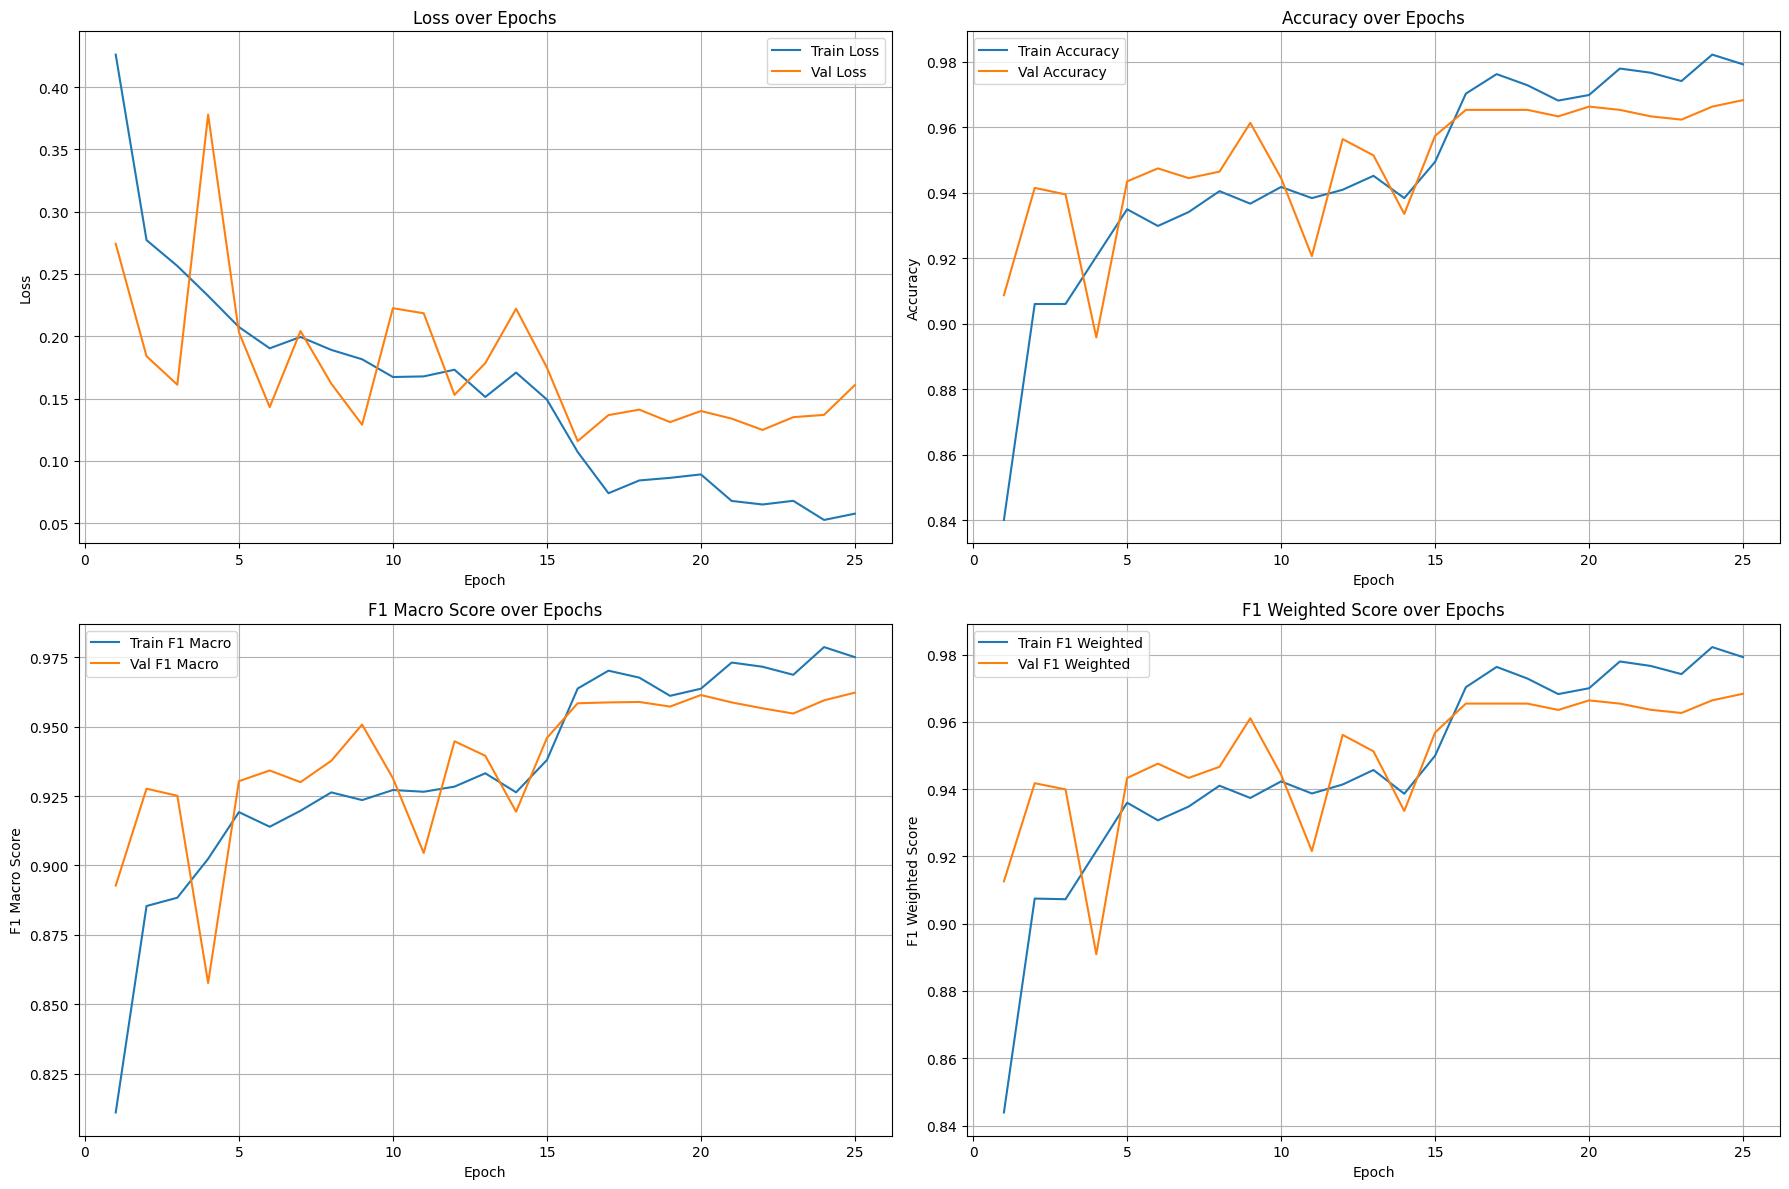

In [10]:
# CELL 9: Plot Progress (Updated to include F1 scores)
# Ensure training actually ran by checking if lists are populated
if train_losses: # Check if any training happened
    epochs_range = range(1, len(train_losses) + 1) # Use actual number of epochs run
    plt.figure(figsize=(18, 12)) # Adjusted figure size for more plots

    # Loss plot
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # F1 Macro plot
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, train_f1_macros, label='Train F1 Macro')
    plt.plot(epochs_range, val_f1_macros, label='Val F1 Macro')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Macro Score')
    plt.title('F1 Macro Score over Epochs')
    plt.legend()
    plt.grid(True)

    # F1 Weighted plot
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, train_f1_weighteds, label='Train F1 Weighted')
    plt.plot(epochs_range, val_f1_weighteds, label='Val F1 Weighted')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Weighted Score')
    plt.title('F1 Weighted Score over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No training data to plot. Please run the training cell (Cell 7).")